<center><h1>CS F469 IR Assignment - 1</h1></center><br>
<center><div>Task:
Retrieving a passage/paragraph information for the specific section from the listed documents.</div></center>


In [129]:
# Installing required packages for this Assignment
!pip install nltk
!pip install PyPDF2
!pip install pandas
!pip install docx2txt
!pip install pytesseract
!pip install sklearn
!pip install pycryptodome
!pip install wordcloud

     -------------------------------------- 153.1/153.1 kB 1.0 MB/s eta 0:00:00


In [130]:
# Import Reqd Packages
import nltk
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from collections import defaultdict
import os
import PyPDF2
import pandas as pd
import collections
import math
from typing import List
import json
import time
from sklearn.feature_extraction.text import TfidfVectorizer
import docx2txt
import pytesseract
from PIL import Image
import numpy as np
import pickle
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt

## Extracting Raw Text From Documents

Below Code can extract raw text from any kind of document such as PDF, word document or Image.

For convenience, we have already saved the preprocessed paragraphs as a pickle file, allowing user to use them directly without the need to preprocess the documents every time

In [131]:
# We have already stored the preprocessed paragraphs in the form of pickle file for the convinience 
# so that  we can use it directly without need to preprocess the docs everytime.

with open("paragraphs_extracted", "rb") as data:
    paragraphs = pickle.load(data)

Below is the code that was used to preprocess data and obtain the paragraphs from the files

In [2]:
# setting the path of the parent folder
parent_folder_path = 'C:/Users/bpran/Downloads/IR-Assignment-1-master/IR-Assignment-1-master/Property'


# initialising a variable to store data/ raw text
text = ""

# looping through all the directories in the parent folder
for dirpath, dirnames, filenames in os.walk(parent_folder_path):
    
    # looping through all the files in the directory
    for filename in filenames:
        filepath = os.path.join(dirpath, filename)                          # this keeps the full filePath
        
        # check if the file is a PDF
        if filename.endswith('.pdf'):                                       # Only process PDF files
            with open(filepath, 'rb') as pdf_file:
                reader = PyPDF2.PdfReader(pdf_file)
                # Loop through each page in the PDF file
                for page_num in range(len(reader.pages)):
                    text += reader.pages[page_num].extract_text()
                    
        elif filename.endswith('.docx'):                                    # Only process DOCX files
            text+="\n \n"
            text+=doc2txt.process(filepath)
            
        elif filename.endswith(('.jpg', '.jpeg', '.png', '.gif')):
            text+="\n \n"                                                   # Only process Image files
            text = pytesseract.image_to_string(Image.open(filepath), lang='eng')

In [3]:
# some of these are because of waterMark
text = text.replace('\t', ' ')
text = text.replace("SAMPLE DOCUMENT",'')
text = text.replace('\n','')

In [4]:
# Let us print the raw text can think about our future steps
text

'     Ontario Automobile Policy  (OAP 1)  Owner’s Policy       Approved by the Superintendent of Financial Services for use as the standard Owner\'s Policy on or after June 1, 2016  ii   About This Policy   This is your automobile insurance policy.  It is writte n in easy to understand language.  Please read it carefully so you know your rights and obligations and the rights and obligations of your insurance company.  Here is a summary of each Section of the policy.  For details of each coverage and the conditions that apply, consult the appropriate Sections of the policy.  Section 1 - Introduction  contains information that applies to the entire policy.  In order to understand what is covered and what is not covered by each coverage, you should read Sections 1 and 2 and the entire  Section of the policy that deals with the specific coverage.  Section 2 - What Automobiles Are Covered  explains what coverages are available to a described automobile and to other types of automobiles (for

#  Normalization
Normalization refers to the process of transforming text into a standard format or structure. This can involve various steps, such as converting text to lowercase, removing punctuation, and expanding contractions. The goal of normalization is to reduce variation in the text and make it easier to process and analyze.

<b>Word-level tokenization:</b> This involves breaking down text into individual words or word-like units, using whitespace or punctuation marks as delimiters. <br>
<b>Sentence-level tokenization:</b> This involves breaking down text into individual sentences, using punctuation marks or other indicators as delimiters. <br>
<b>Removal Of Stop Words:</b> These words are considered noise in the data and can often be safely ignored without affecting the overall meaning of the text. <br>
<b>Lemmatization:</b> The goal of lemmatization is to normalize words to a standard form that can be easily compared and analyzed. <br>

In [5]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Tokenize the text into words and sentences
def text_normalization(text):
    words = word_tokenize(text)
    sentences = sent_tokenize(text)

    # Remove stop words and punctuation
    stop_words = set(stopwords.words('english'))
    words = [word.lower() for word in words if word.isalpha() and word.lower() not in stop_words]

    # Lemmatize the words -> Reduct the words into their base form
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a sentence
    normalized_text = ' '.join(words)
    return normalized_text

[nltk_data] Error loading punkt: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>
[nltk_data] Error loading omw-1.4: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     self signed certificate in certificate chain
[nltk_data]     (_ssl.c:1129)>


#### We have written a function that tokenizes the extrated text on the basis of paragraphs.

In [6]:
def tokenize_paragraphs(text):
    sentences = nltk.sent_tokenize(text)
    paragraphs = []
    current_paragraph = ""
    for i, sentence in enumerate(sentences):
        if i % 5 == 0 and i > 0:
            paragraphs.append(current_paragraph)
            current_paragraph = sentence
        else:
            current_paragraph += " " + sentence
    if current_paragraph:
        paragraphs.append(current_paragraph)
    return paragraphs

In [7]:
%%time
paragraphs = tokenize_paragraphs(text)

Wall time: 13.5 s


In [132]:
# Checking the number of parapgraphs extracted
len(paragraphs)

1205

In [125]:
# Saving paragraphs list so that we can use it directly without need to preprocess the docs everytime
with open("paragraphs_extracted", "wb") as output:
    pickle.dump(paragraphs, output)

In [10]:
# printing all the extracted paragraphs.
# Having a look at our data to be operated
for p in paragraphs:
    print(p +'\n' + '*'*100)


      Ontario Automobile Policy  (OAP 1)  Owner’s Policy       Approved by the Superintendent of Financial Services for use as the standard Owner's Policy on or after June 1, 2016  ii   About This Policy   This is your automobile insurance policy. It is writte n in easy to understand language. Please read it carefully so you know your rights and obligations and the rights and obligations of your insurance company. Here is a summary of each Section of the policy. For details of each coverage and the conditions that apply, consult the appropriate Sections of the policy.
****************************************************************************************************

Section 1 - Introduction  contains information that applies to the entire policy. In order to understand what is covered and what is not covered by each coverage, you should read Sections 1 and 2 and the entire  Section of the policy that deals with the specific coverage. Section 2 - What Automobiles Are Covered  explain

In [133]:
%%time

#normalizing the extracted text using previously defined functions
normalized_paragraphs = []
for text in paragraphs:
    normalized_text = text_normalization(text)
    normalized_paragraphs.append(normalized_text)

Wall time: 3.3 s


In [134]:
normalized_paragraphs

['ontario automobile policy oap owner policy approved superintendent financial service use standard owner policy june ii policy automobile insurance policy writte n easy understand language please read carefully know right obligation right obligation insurance company summary section policy detail coverage condition apply consult appropriate section policy',
 'section introduction contains information applies entire policy order understand covered covered coverage read section entire section policy deal specific coverage section automobile covered explains coverage available described automobile type automobile example newly acquired temporary substitute automobile specific coverage described automobile section liability coverage describes cover someone killed injured accident property damaged insured perso n fault accident section accident benefit coverage outline benefit available injured accident regardless caused accident',
 'section uninsured automobile coverage describes cover so

# Generating Inverted Index
This will map unique words with the ID of paragraphs they are present in<br>
Finally, we also include IDF of every term in the inverted index. <br>
The IDF is used to downweight the importance of terms that occur in many documents, and to emphasize the importance of terms that occur in few documents.

In [135]:
def create_inverted_index(sentences):
    
    # Initialize the inverted index and count the number of documents
    inverted_index = defaultdict(dict)
    num_docs = len(sentences)

    # Iterate over each sentence and tokenize its words
    for i, sentence in enumerate(sentences):
        terms = word_tokenize(sentence)
        seen_terms = set()

         # Count the frequency of each term in the sentence
        for term in terms:
            if term not in seen_terms:
#                 inverted_index[term][i] = inverted_index[term].get(i, 0) + 1
                inverted_index[term][i] = terms.count(term)
                seen_terms.add(term)

    # Compute the IDF of each term in the index
    for term in inverted_index:
        df = len(inverted_index[term])
        idf = 1.0 + math.log(num_docs / df)
        inverted_index[term]['idf'] = idf
    
    # compute the TF of each term in the index    
    for term in inverted_index:
        tf = sum(inverted_index[term].values())
        inverted_index[term]['tf'] = tf
    return inverted_index

In [136]:
%%time
inverted_index = create_inverted_index(normalized_paragraphs)

Wall time: 1.42 s


In [137]:
inverted_index

defaultdict(dict,
            {'ontario': {0: 1,
              2: 1,
              3: 1,
              4: 1,
              7: 1,
              8: 1,
              10: 1,
              12: 1,
              13: 1,
              16: 1,
              18: 1,
              19: 1,
              22: 2,
              23: 1,
              26: 1,
              28: 1,
              29: 1,
              30: 1,
              33: 1,
              36: 1,
              39: 1,
              42: 1,
              45: 1,
              48: 1,
              51: 2,
              54: 1,
              57: 2,
              60: 1,
              62: 1,
              63: 1,
              64: 2,
              66: 1,
              67: 2,
              69: 1,
              71: 1,
              74: 1,
              75: 2,
              77: 1,
              80: 1,
              83: 1,
              87: 1,
              89: 1,
              90: 1,
              92: 3,
              93: 2,
              94: 1,
           

Lets have a look at wordcloud for the documents to get a visual summary of the most important or prominent words in the documnets

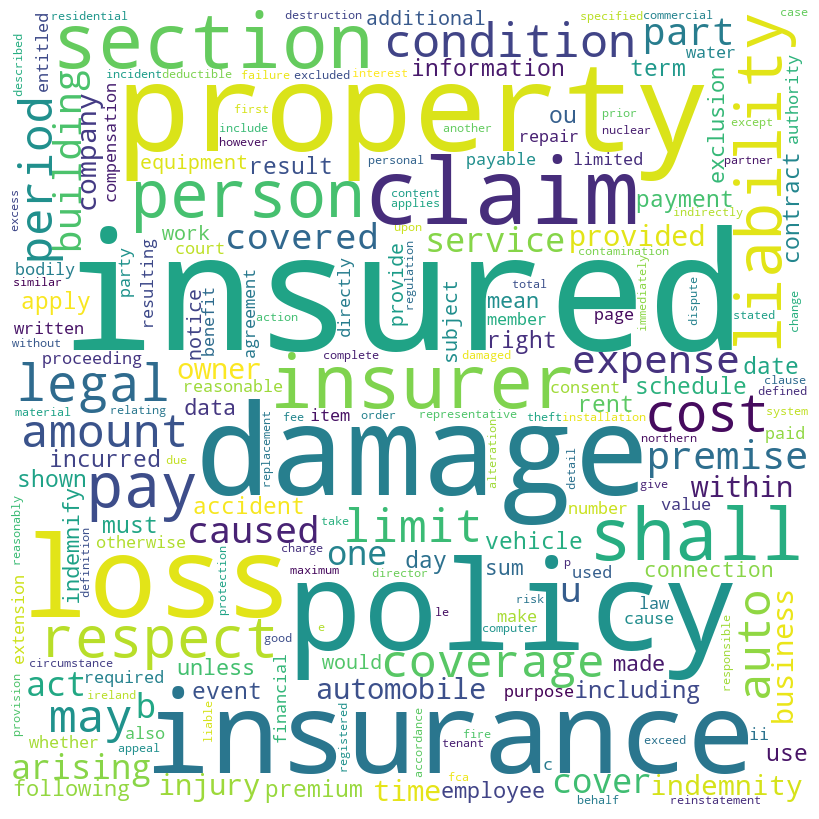

In [141]:
# create a list of tuples from the inverted index
word_freq = [(term, sum(data.values())) for term, data in inverted_index.items()]

# create a word cloud object
wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate_from_frequencies(dict(word_freq))

# plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
  
# show the plot
plt.show()

In [140]:
# create a dataframe from the inverted index
df1 = pd.DataFrame([(term, paragraph, frequency) for term, data in inverted_index.items() for paragraph, frequency in data.items()],
                  columns=['Term', 'Paragraph', 'Frequency'])

# display the dataframe
df1.head(5)


Term Paragraph  Frequency
0  ontario         0        1.0
1  ontario         2        1.0
2  ontario         3        1.0
3  ontario         4        1.0
4  ontario         7        1.0

<center><h2>Query Search</h2></center>

Below is a function that calculates cosine similarity between a query ans a collectin of documents represented by inverted index. The function first calculates the weight of each term in the query using the term frequency (TF) scheme, and then computes the length of the query vector. It then iterates over the terms in the query and for each term, retrieves the set of documents that contain it and its IDF value from the inverted index. It then calculates the dot product of the query vector and the document vectors, weighted by the IDF values, and stores the results in a dictionary.

Next, the function computes the length of each document vector and the cosine similarity between the query vector and each document vector, and stores the results in a dictionary. Finally, the function returns the top five paragraphs that have the highest cosine similarity score with the query, along with the sorted similarity scores for all the documents.

In [104]:
def cosine_similarity(inverted_index, paragraphs , query):
    """
    Calculate the cosine similarity between a query and documents represented by an inverted index.
    """
    query_weights = {}
    query_terms = query.split()
    query_length = 0

    # Calculate the weight of each query term
    for term in query_terms:
        query_weights[term] = query_weights.get(term, 0) + 1
        query_length += query_weights[term] ** 2

    query_length = math.sqrt(query_length)
    
#     print(query_weights)
    
    # Calculate the dot product of the query and each document
    scores = {}
    for term in query_terms:
        if term in inverted_index:
            idf = inverted_index[term]['idf']
            for doc_id, tf in inverted_index[term].items():
                if doc_id != 'idf':
                    scores[doc_id] = scores.get(doc_id, 0) + query_weights[term] * tf * idf

    # Calculate the cosine similarity between the query and each document
    result = {}
    for doc_id, score in scores.items():
        doc_length = 0
        for term, tf in inverted_index.items():
            if doc_id in tf:
                doc_length += tf[doc_id] ** 2 * inverted_index[term]['idf'] ** 2
        doc_length = math.sqrt(doc_length)
        similarity = score / (query_length * doc_length)
        result[doc_id] = similarity

    # Sort the result by similarity score
    sorted_result = sorted(result.items(), key=lambda x: x[1], reverse=True)
    #print(sorted_result)
    
    # Return the document with the highest similarity
    top_results = []
    for i in range(min(10, len(sorted_result))):
        top_result = sorted_result[i]
        doc_id = top_result[0]
        similarity = top_result[1]
        top_results.append(paragraphs[doc_id])

    return top_results, sorted_result

Below is a function which takes in <b> list of paragraph </b> and returns a <b> list of paragraph that contain the exact phrase </b><br>

The exact phrase looks like <<••HIGHLIGHTED_TEXT••>>

In [105]:
def PhraseQuery(sentences, query):

    # Iterate over the sentences and find the ones that match the query
    matching_sentences = []
    for sentence in sentences:
        match = re.search(r'\b{}\b'.format(query), sentence)
        if match:
            # Surround the matching part of the sentence with other characters
            highlighted_sentence = sentence[:match.start()] + "<<••" + match.group() + "••>>" + sentence[match.end():]
            matching_sentences.append(highlighted_sentence)
    
    # If no matches are found, return an empty list
    return matching_sentences

below function takes in a list of paragraph and query as input and returns the paragraphs which satisfy the <b>BOOLEAN query</b>.

In [106]:
def AdvanceBOOLQuery(sentences, query):
    # Split the query into separate keywords and operators
    keywords = query.split()
    operators = []
    for i in range(1, len(keywords), 2):
        operators.append(keywords[i])
    keywords = [keyword for keyword in keywords if keyword not in operators]

    # Iterate over the sentences and find the ones that match the query
    matching_sentences = []
    for sentence in sentences:
        # Check if the sentence matches the query
        sentence_matches_query = True
        for i in range(len(keywords)):
            # Check if the keyword is in the sentence
            keyword_matches_sentence = (keywords[i] in sentence)

            # Combine with the previous result based on the operator
            if i == 0:
                sentence_matches_query = keyword_matches_sentence
            elif operators[i-1] == "AND":
                sentence_matches_query = sentence_matches_query and keyword_matches_sentence
            elif operators[i-1] == "OR":
                sentence_matches_query = sentence_matches_query or keyword_matches_sentence

        # If the sentence matches the query, highlight the matching words
        if sentence_matches_query:
            for keyword in keywords:
                sentence = sentence.replace(keyword, f"<<••{keyword}••>>")
            matching_sentences.append(sentence)

    # If no matches are found, return an empty list
    return matching_sentences

In [107]:
query = input("Give Your Query: ")

Give Your Query: Computer AND Damage


In [108]:
matching_sentences = AdvanceBOOLQuery(paragraphs, query)
print(len(matching_sentences))
for p in matching_sentences:
    print(f"• {p}")
    print("\n")

25
• £25 to cover operational costs. The amount of any premium to be refunded under this condition will be reduced by all unpaid premiums or unpaid premium instalments due.If the Insurer exercises the right to suspend or cancel cover, then provided no claim has been made or incident has arisen which is likely to give rise to a claim during the current Period of Insurance the Insured will be entitled to a proportionate return of the premium in respect of such period that cover is suspended or for any period beyond the effective date from which cover is cancelled. The amount of premium refund payable will be reduced by all unpaid premiums or unpaid premium instalments due.Except in so far as they are expressly varied by this condition, all of the terms, conditions, provisions, exclusions and limits of the Policy and of the Sections of the Policy shall continue to apply until the Insurer advises otherwise. To the extent that this condition conflicts with any other cancellation condition, 

In [109]:
if query[0]=='"' and query[-1]=='"':
    query = query[1:-1]
    matching_paragraphs = PhraseQuery(paragraphs, query)
    print("Presenting Paragraphs with exact lines: \n")
    # Combine the matching sentences into a single string with line breaks
    if len(matching_paragraphs)==0:
        print("No matching paragraph found!")
    else:
        print(f"We received {len(matching_paragraphs)} results!\n\n")
        for p in matching_paragraphs:
            print(f"• {p}")
            print("\n")
elif ("AND" or "OR") in query.split():
    print(query.split())
    matching_paragraphs = AdvanceBOOLQuery(paragraphs, query)
    print("Presenting Paragraphs with all the words: \n")    
    if len(matching_paragraphs)==0:
        print("No matching paragraph found!")
    else:
        print(f"We received {len(matching_paragraphs)} results!\n\n")
        for p in matching_paragraphs:
            print(f"• {p}")
            print("\n")
else:
    print("NO ADVANCE SEARCHES!")

['Computer', 'AND', 'Damage']
Presenting Paragraphs with all the words: 

We received 25 results!


• £25 to cover operational costs. The amount of any premium to be refunded under this condition will be reduced by all unpaid premiums or unpaid premium instalments due.If the Insurer exercises the right to suspend or cancel cover, then provided no claim has been made or incident has arisen which is likely to give rise to a claim during the current Period of Insurance the Insured will be entitled to a proportionate return of the premium in respect of such period that cover is suspended or for any period beyond the effective date from which cover is cancelled. The amount of premium refund payable will be reduced by all unpaid premiums or unpaid premium instalments due.Except in so far as they are expressly varied by this condition, all of the terms, conditions, provisions, exclusions and limits of the Policy and of the Sections of the Policy shall continue to apply until the Insurer advis

In [110]:
# normalizing the query
normalized_query = text_normalization(query)

In [111]:
%%time
results, sorted_rs = cosine_similarity(inverted_index,normalized_paragraphs,normalized_query)

Wall time: 1.01 s


In [112]:
# from tabulate import tabulate

# table = []

# if len(results) > 0:
#     print("The top matching sentences are:\n")
#     for i, result in enumerate(results):
#         table.append([i+1, result])

#     print(tabulate(table, headers=['Rank', 'Matching Sentence'], tablefmt='grid'))
# else:
#     print("No matching sentences found")

# Printing the result
if len(results) > 0:
    print("The top matching sentences are:\n")
    for result in results:
        print(f"• {result}")
        print("\n")
        
else:
    print("No matching sentences found")


The top matching sentences are:

• fire extinguishing expense insurance section extends include cost incurred insured recharging replenishing replacing fire extinguishing appliance othe r gas flooding system replacing sprinkler head automatic sprinkler installation rendered necessary result fire premise liability admitted section incompatibility computer record company wi pay cost modification computer equipment b cost replacement computer equipment together reinstatement program data thereon whichever le achieve compatibility event loss destruction computer equipment insured section resulted undamaged computer equipment incompatible replacement computer equipment


• computer data shall mean data sort whatever including without limitation tangible intangible data program software bandwidth cryptographic key database document domain name network address anything similar file interface metadata platform processing capability storage medium transaction gateway user credential web ites in

# Calculating Mean Reciprocal Rank (MRR)

The MRR (Mean Reciprocal Rank) measures the position of the first relevant document within a ranking. A value close to 1 indicates that relevant results are near the top of the search results, which is desirable. Conversely, lower MRR values indicate poorer search quality, with relevant results farther down the list.

For a single query, the reciprocal rank is 1/rank where rank is the position of the highest-ranked answer (1,2,3...,N for N answers returned in a query). If no correct answer was returned in the query, then the reciprocal rank is 0.

In evaluating our model, we utilized MRR instead of precision or recall. Precision and recall require knowledge of all relevant documents to determine which ones are pertinent to a given query. However, since we lacked ground-truth results, we were unable to calculate precision and recall.

To calculate the MRR, we created an Excel file named "query_file" that contained the paragraph index corresponding to each query from which the query was directly copied.

In [113]:
df= pd.read_csv("query_file.csv")
df

Query  Desired Paragraph Index
0                                   Actual cash value                      144
1                      Motorized vehicle registration                      174
2                      Punitive and Exemplary Damages                      561
3        faulty  materials  used  in its construction                      688
4                          electronic data processing                      482
5   devices permanently installed in a motorized v...                      193
6                               Business interruption                      874
7                                        Credit cards                      197
8                                 fund transfer cards                      197
9                             REMOVAL OF FALLEN TREES                      201
10                           DEBRIS  AND VOLCANIC ASH                      207
11                                 EMERGENCY MEASURES                      622
12                                      FOOD SPOILAGE                      210
13                                   FORGERY coverage                      211
14                                    ABRUPT COLLAPSE                      212
15                               automatic fire alarm                      942
16                            Rights of Third Parties                      593
17                                Payments on Account                      532
18                         ground  heave  or landslip                      944
19                                  faulty  materials                      932
20                          Ontario Automobile Policy                       48
21                                 business in the UK                     1203
22                                    Computer damage                      853

In [114]:
#calculating MRR

mrr = 0  
ranks = []  # to store the rank of the most relevant document obtained for each query
duration=[] # to store time taken for retrieval for each query

for i in range(df.shape[0]):
    normalized_query = text_normalization(df.iloc[i,0])
    begin= time.time()
    rs, sorted_rs = cosine_similarity(inverted_index,paragraphs,normalized_query)
    end= time.time()
    duration.append(end-begin)

    result= [ls[0] for ls in sorted_rs]
    if df.iloc[i,1] not in result:     # if no correct answer found, rank=0
            rank=0
    else:
        rank= result.index(df.iloc[i,1]) +1   

    if rank == 0:
        pass
    else:
        mrr+= 1/rank

    ranks.append(rank)

mrr= mrr/df.shape[0]    # calculating mean of the reciprocal ranks

In [115]:
# closer the value of MRR to 1, better the search engine
mrr

0.8239130434782609

In [116]:
# we see that for each query we are getting results mostly in top 5
ranks

[1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 1, 2, 1, 1, 5]

In [117]:
# Average time taken for searching a query
np.mean(duration)

0.2815103945524796